# Unsupervised learning Project 1 (page 96)

In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline
'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
file = 'datasets/mnist_data/mnist.pkl.gz'
f = gzip.open(file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [3]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [4]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [5]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train), len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [6]:
def view_digit(example):
    label = y_train.loc[0]
    image = X_train.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

In [7]:
from sklearn.decomposition import PCA
n_components = 784
whiten = False
random_state = 2018
pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

In [8]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [9]:
"Variance Explained by all 784 principal components: " + str(sum(pca.explained_variance_ratio_))

'Variance Explained by all 784 principal components: 0.9999999550829073'

In [10]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T
print('Variance Captured by First 10 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ',
importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.48876232]
Variance Captured by First 20 Principal Components:  [0.64398026]
Variance Captured by First 50 Principal Components:  [0.8248609]
Variance Captured by First 100 Principal Components:  [0.91465855]
Variance Captured by First 200 Principal Components:  [0.96650076]
Variance Captured by First 300 Principal Components:  [0.98624885]


In [11]:
(pd.DataFrame(data=pca.explained_variance_ratio_).T)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.097444,0.070598,0.062161,0.053795,0.048581,0.043196,0.032776,0.028864,0.027688,0.023659,...,1.254956e-16,1.254956e-16,1.254956e-16,1.254956e-16,1.254956e-16,1.229925e-16,1.199071e-16,6.439675e-17,2.590294e-17,1.362777e-17


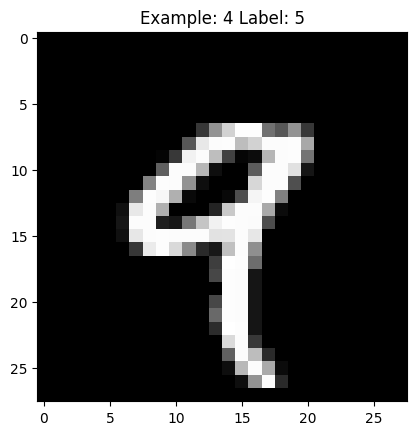

In [12]:
view_digit(4)

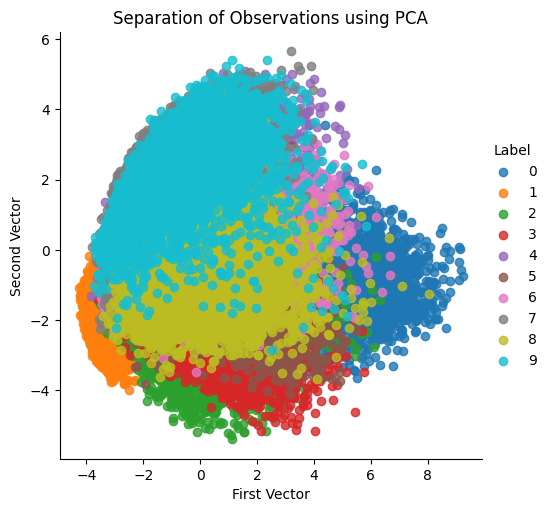

In [13]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
    data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

scatterPlot(X_train_PCA, y_train, "PCA")

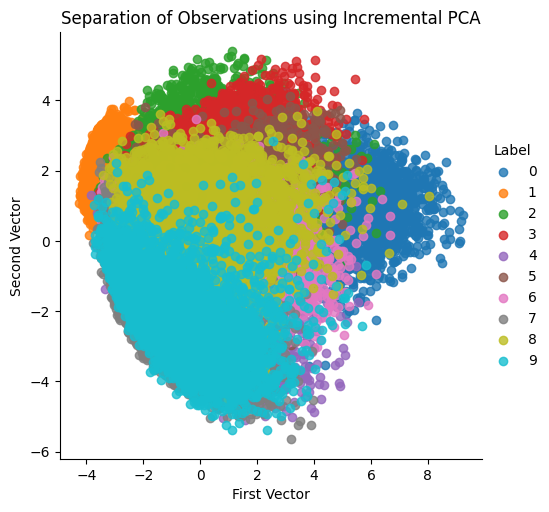

In [14]:
from sklearn.decomposition import IncrementalPCA
n_components = 784
batch_size = None
incrementalPCA = IncrementalPCA(n_components=n_components, \
batch_size=batch_size)
X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA, index=train_index)
X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA, index=validation_index)
scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")

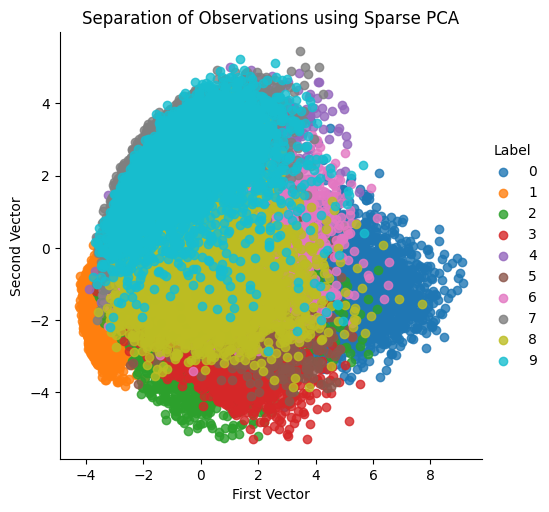

In [15]:
# Sparse PCA
from sklearn.decomposition import SparsePCA
n_components = 100
alpha = 0.0001
random_state = 2018
n_jobs = -1
sparsePCA = SparsePCA(n_components=n_components, \
alpha=alpha, random_state=random_state, n_jobs=n_jobs)
sparsePCA.fit(X_train.loc[:10000,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)
X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = \
pd.DataFrame(data=X_validation_sparsePCA, index=validation_index)
scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

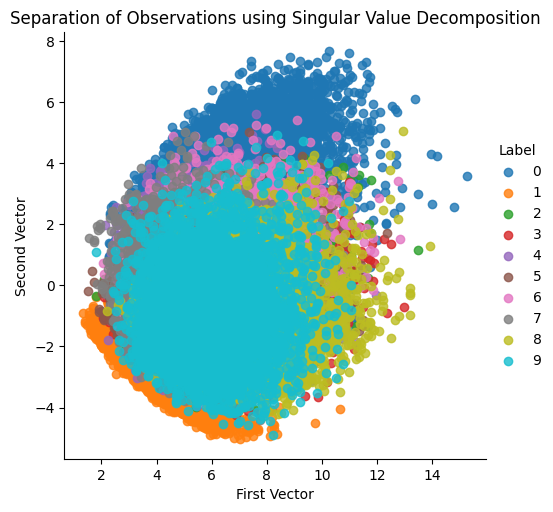

In [16]:
# Singular Value Decomposition
from sklearn.decomposition import TruncatedSVD
n_components = 200
algorithm = 'randomized'
n_iter = 5
random_state = 2018
svd = TruncatedSVD(n_components=n_components, algorithm=algorithm, \
n_iter=n_iter, random_state=random_state)
X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)
X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd, index=validation_index)
scatterPlot(X_train_svd, y_train, "Singular Value Decomposition")